In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /home/csuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read in Training Data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Read in the values that we will predict and submit

In [3]:
submission_set = pd.read_csv('test.csv')
submission_set.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Drop keyword and location from data: too many missing vals

In [4]:
train = train.drop(['keyword', 'location'], axis=1)
submission_set = submission_set.drop(['keyword', 'location'], axis=1)
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# Remove stopwords and punctuation from the data

In [6]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

train['text'] = train['text'].apply(get_text_processing)
submission_set['text'] = submission_set['text'].apply(get_text_processing)
submission_set.head()

,id,text
0,0,happened terrible car crash
1,2,Heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 China Taiwan


# Split training data frame into train and test sets: we'll use these to train and score the classifier

In [11]:
X = train['text'].values
y = train['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Vectorize our NLP data and standardize it

In [12]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)
X_submission = vect.transform(submission_set['text'])

<3263x17380 sparse matrix of type '<class 'numpy.int64'>'
	with 24332 stored elements in Compressed Sparse Row format>

In [13]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()
X_submission = tfidf.fit_transform(X_submission)
X_submission = X_submission.toarray()

In [14]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
X_submission = sc.transform(X_submission)

# Create and train our model

In [15]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [16]:
model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/10
167/167 [==============================] - 10s 62ms/step - loss: 1.4265 - accuracy: 0.5941 - val_loss: 0.5306 - val_accuracy: 0.7237
Epoch 2/10
167/167 [==============================] - 10s 60ms/step - loss: 0.4982 - accuracy: 0.8078 - val_loss: 0.6873 - val_accuracy: 0.7513
Epoch 3/10
167/167 [==============================] - 10s 60ms/step - loss: 0.2172 - accuracy: 0.9426 - val_loss: 1.2446 - val_accuracy: 0.7504
Epoch 00003: early stopping


# Check the accuracy:

In [17]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

36/36 [==============================] - 0s 11ms/step - loss: 1.2446 - accuracy: 0.7504
Test accuracy: 0.75043785572052


# Our accuracy was a little low so we can try another type of classifier:

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced_subsample')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1)

In [19]:
rfc.score(X_test, y_test)

0.776707530647986

# Make prediction on the submission data and write it to a CSV file

In [22]:
predictions = rfc.predict(X_submission)

In [29]:
target_df = pd.DataFrame(predictions, columns=['target'])
submission_df = pd.concat([submission_set['id'], target_df], axis=1)

In [38]:
submission_df.to_csv('submission.csv', index=False)

# My Submission

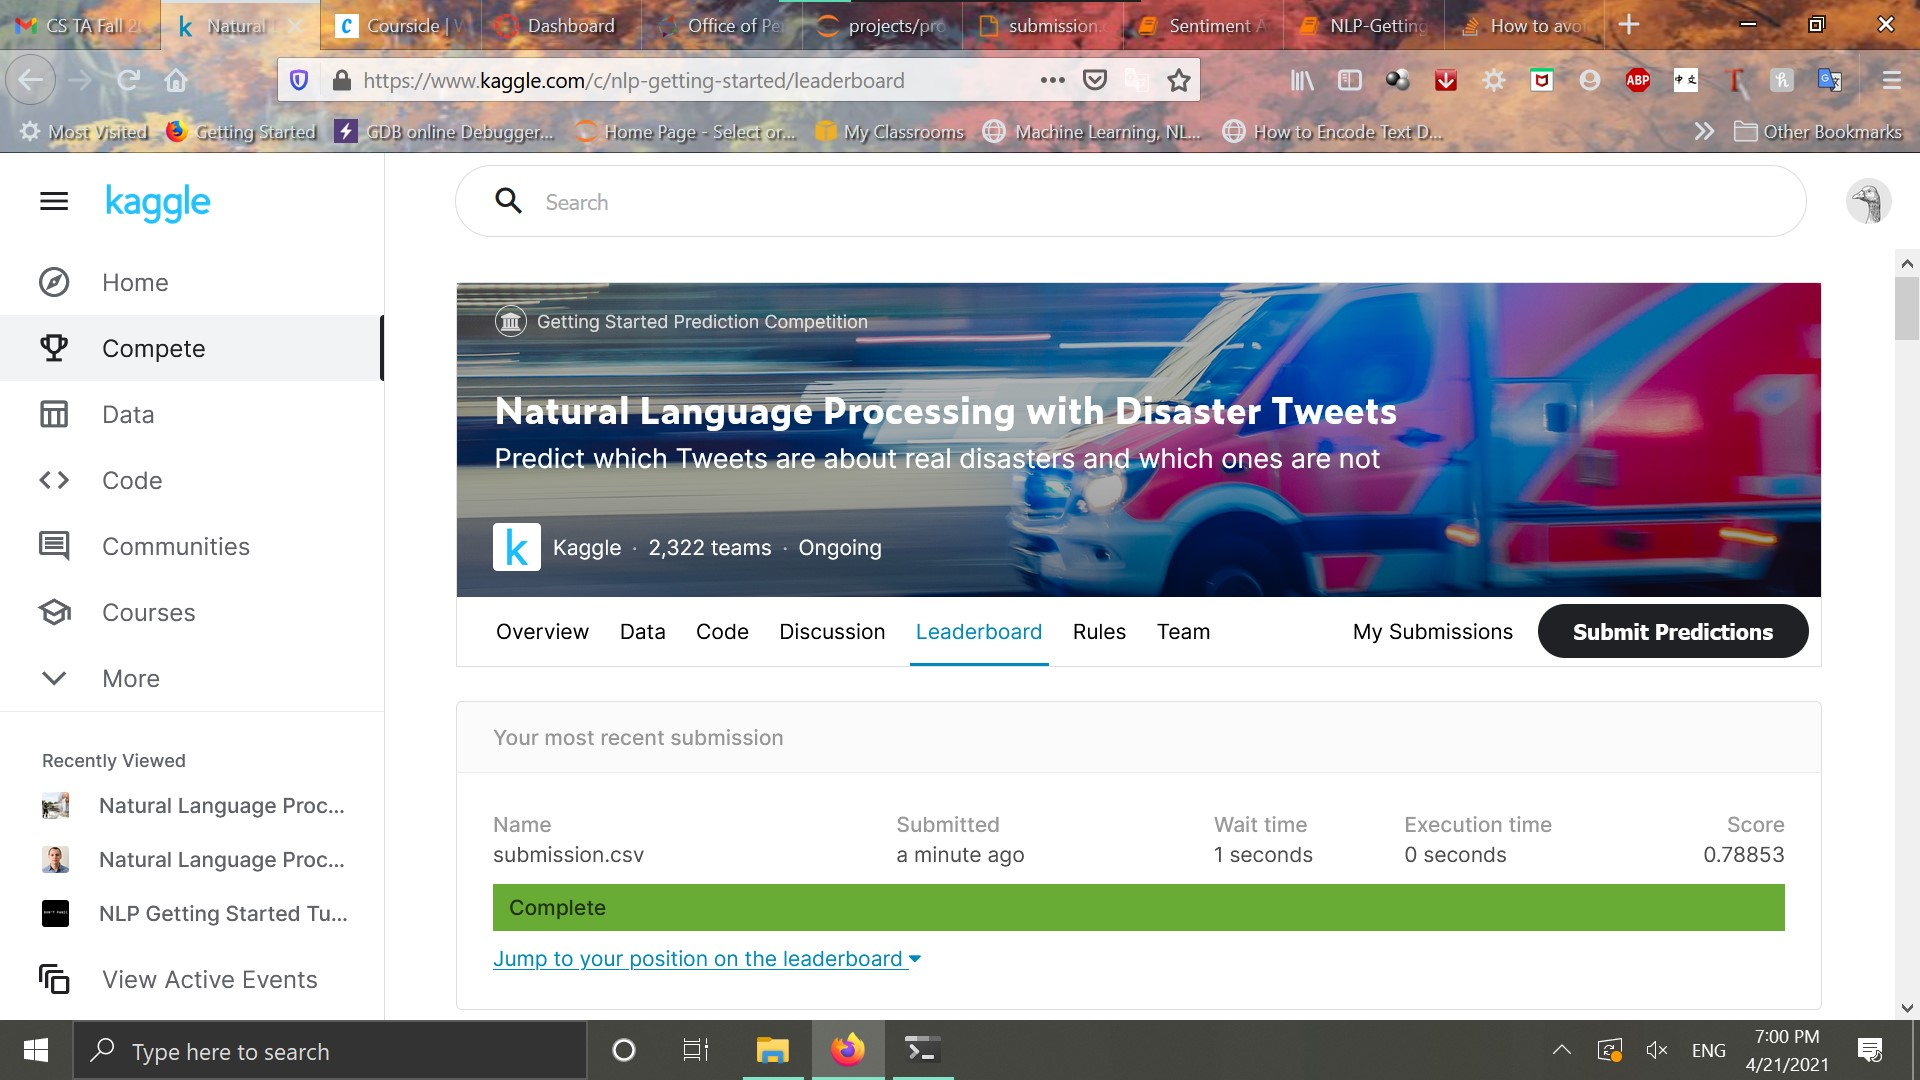

In [1]:
from IPython.display import Image
Image(filename='kaggle_submission.jpg')